<a href="https://colab.research.google.com/github/malacosteus/RaifhackDS/blob/main/RaifhackDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn==0.24.1

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3 MB 1.4 MB/s 


In [3]:
from sklearn.compose import ColumnTransformer

In [4]:
import numpy as np
import pandas as pd
import gc
import random
import re
import typing
import numpy as np

#import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

import pickle

In [5]:
# реализация метрики от организаторов
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array) -> typing.Dict[str,float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 'mdape':mdape, 'rmse': rmse, 'r2': r2, 'raif_metric':raif_metric}

In [6]:
PATH_TO_DATA = '../content/drive/MyDrive/Raifhack/data/'

In [7]:
# загрузка данных
train_df = pd.read_csv(PATH_TO_DATA+'train.csv', low_memory=False)
test_df = pd.read_csv(PATH_TO_DATA+'test.csv', low_memory=False)
test_submission = pd.read_csv(PATH_TO_DATA+'test_submission.csv', low_memory=False)

In [8]:
NUM_FEATURES = ['lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
      'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
       'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
       'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
       'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
       'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
       'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
       'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
       'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
       'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
       'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01',
       'osm_transport_stop_closest_dist', 'osm_transport_stop_points_in_0.005',
       'osm_transport_stop_points_in_0.0075',
       'osm_transport_stop_points_in_0.01',
       'reform_count_of_houses_1000', 'reform_count_of_houses_500',
       'total_square']

In [9]:
CATEGORICAL_STE_FEATURES = ['region', 'city', 'realty_type']

In [10]:
CATEGORICAL_OHE_FEATURES = []

In [11]:
TARGET = 'per_square_meter_price'

In [12]:
from enum  import IntEnum

class PriceTypeEnum(IntEnum):

    OFFER_PRICE = 0 # цена из объявления
    MANUAL_PRICE = 1 # цена, полученная путем ручной оценки

In [13]:
#исходные параметры
MODEL_PARAMS = dict(
            n_estimators=2000,
            learning_rate=0.01,
            reg_alpha=1,
            num_leaves=40,
            min_child_samples=5,
            importance_type="gain",
            n_jobs=1,
            random_state=563,
        )

In [14]:
dict(train_df.dtypes)

{'city': dtype('O'),
 'date': dtype('O'),
 'floor': dtype('O'),
 'id': dtype('O'),
 'lat': dtype('float64'),
 'lng': dtype('float64'),
 'osm_amenity_points_in_0.001': dtype('int64'),
 'osm_amenity_points_in_0.005': dtype('int64'),
 'osm_amenity_points_in_0.0075': dtype('int64'),
 'osm_amenity_points_in_0.01': dtype('int64'),
 'osm_building_points_in_0.001': dtype('int64'),
 'osm_building_points_in_0.005': dtype('int64'),
 'osm_building_points_in_0.0075': dtype('int64'),
 'osm_building_points_in_0.01': dtype('int64'),
 'osm_catering_points_in_0.001': dtype('int64'),
 'osm_catering_points_in_0.005': dtype('int64'),
 'osm_catering_points_in_0.0075': dtype('int64'),
 'osm_catering_points_in_0.01': dtype('int64'),
 'osm_city_closest_dist': dtype('float64'),
 'osm_city_nearest_name': dtype('O'),
 'osm_city_nearest_population': dtype('float64'),
 'osm_crossing_closest_dist': dtype('float64'),
 'osm_crossing_points_in_0.001': dtype('int64'),
 'osm_crossing_points_in_0.005': dtype('int64'),
 'o

In [15]:
nans = train_df.isna() 
tbl_nans_tr = nans.apply(pd.Series.value_counts)
tbl_nans_tr

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
False,279792.0,103555,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279737,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,279792.0,265196,252558,263084,249624,263553,250155,279792.0,279792.0,278186,279792.0,279792.0,279792.0
True,NaN,176237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14596,27234,16708,30168,16239,29637,NaN,NaN,1606,NaN,NaN,NaN


In [16]:
train_df['floor'] = train_df['floor'].fillna(1)

In [17]:
train_df['floor'] = pd.to_numeric(train_df['floor'], errors='coerce')

In [18]:
train_df['floor'] = train_df['floor'].astype('float64')

In [19]:
df = train_df.copy()
res = df.drop("per_square_meter_price", axis=1).apply(lambda x: x.corr(df.per_square_meter_price, method="spearman"))

In [37]:
#train_df['floor'].corr(train_df['per_square_meter_price'], method='spearman')

In [20]:
res = pd.DataFrame(res)

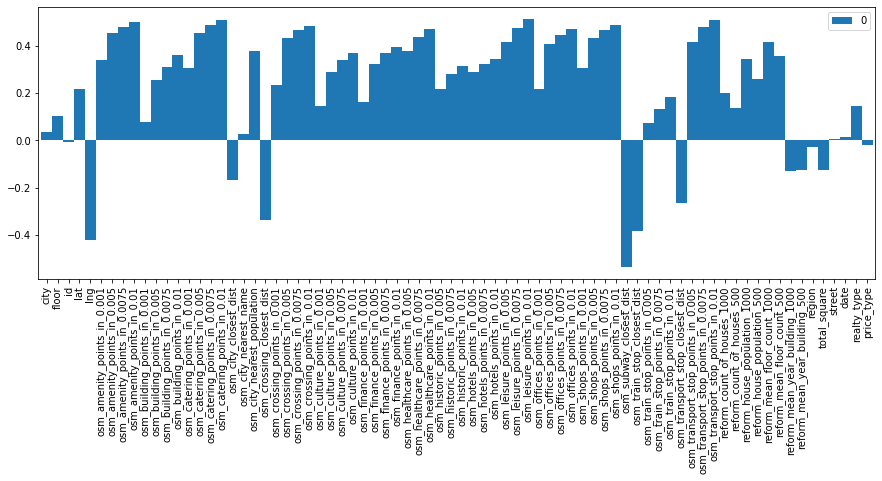

In [21]:
res.plot(kind='bar', width=1, figsize=(15, 5), label='corr_spmn')

In [22]:
class MyModel():
  def __init__(self, numerical_features: typing.List[str],
                 ohe_categorical_features: typing.List[str],
                 ste_categorical_features: typing.List[typing.Union[str, typing.List[str]]],
                 model_params: typing.Dict[str, typing.Union[str, int, float]]):
    
        self.num_features = numerical_features
        self.ohe_cat_features = ohe_categorical_features
        self.ste_cat_features = ste_categorical_features

        self.preprocessor =ColumnTransformer(transformers=[
            ('num', StandardScaler(), self.num_features),
            ('ohe', OneHotEncoder(), self.ohe_cat_features),
            ('ste', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
             self.ste_cat_features)])
        
        self.model = LGBMRegressor(**model_params)

        self.pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('model', self.model)])

        self._is_fitted = False
        self.corr_coef = 0

  def _find_corr_coefficient(self, X_manual: pd.DataFrame, y_manual: pd.Series):
        """Вычисление корректирующего коэффициента

        :param X_manual: pd.DataFrame с ручными оценками
        :param y_manual: pd.Series - цены ручника
        """
        predictions = self.pipeline.predict(X_manual)
        deviation = ((y_manual - predictions)/predictions).median()
        self.corr_coef = deviation

  def fit(self, X_offer: pd.DataFrame, y_offer: pd.Series,
            X_manual: pd.DataFrame, y_manual: pd.Series):
        """Обучение модели.
        ML модель обучается на данных по предложениям на рынке (цены из объявления)
        Затем вычисляется среднее отклонение между руяными оценками и предиктами для корректировки стоимости

        :param X_offer: pd.DataFrame с объявлениями
        :param y_offer: pd.Series - цена предложения (в объявлениях)
        :param X_manual: pd.DataFrame с ручными оценками
        :param y_manual: pd.Series - цены ручника
        """
        self.pipeline.fit(X_offer, y_offer, model__feature_name=[
                          f'{i}' for i in range(64)], model__categorical_feature=['61', '62', '63'])
        if X_manual.size > 0:
            self._find_corr_coefficient(X_manual, y_manual)

  def predict(self, X: pd.DataFrame) -> np.array:
        """Предсказание модели Предсказываем преобразованный таргет, затем конвертируем в обычную цену через обратное
        преобразование.

        :param X: pd.DataFrame
        :return: np.array, предсказания (цены на коммерческую недвижимость)
        """
        predictions = self.pipeline.predict(X)
        corrected_price = predictions;# * (1 + self.corr_coef)
        return corrected_price
        

  def save(self, path: str):
        """Сериализует модель в pickle.

        :param path: str, путь до файла
        """
        with open(path, "wb") as f:
            pickle.dump(self, f)

  @classmethod
  def load(self, path: str):
        """Сериализует модель в pickle.

        :param path: str, путь до файла
        :return: Модель
        """
        with open(path, "rb") as f:
            model = pickle.load(f)
        return model


In [23]:
def prepare_data(df):
   df = df.drop(columns=['id', 'date', 'street'])
   df = df.drop(columns=['reform_house_population_1000', 'reform_house_population_500', 'reform_mean_floor_count_1000', 'reform_mean_floor_count_500', 'reform_mean_year_building_1000', 'reform_mean_year_building_500'])
   print(type(df))

   for i in NUM_FEATURES:
    df[i] = df[i].fillna(1)
    df[i] = pd.to_numeric(df[i], errors='coerce')
    df[i] = df[i].astype('float64')
   print(type(df))

In [37]:
def train(model, train_df):

        prepare_data(train_df)

        X_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
        y_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][TARGET]
        X_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
        y_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][TARGET]
        model = MyModel(numerical_features=NUM_FEATURES, ohe_categorical_features=CATEGORICAL_OHE_FEATURES,
                                  ste_categorical_features=CATEGORICAL_STE_FEATURES, model_params=params_lgbm)
        
        model.fit(X_offer, y_offer, X_manual, y_manual)
    
        model.save('/content/drive/MyDrive/Raifhack/baseline.sav')

        predictions_offer = model.predict(X_offer)
        metrics = metrics_stat(y_offer.values, predictions_offer/(1+model.corr_coef)) 
        print('Metrics stat for training data with offers prices:', metrics)

        predictions_manual = model.predict(X_manual)
        metrics = metrics_stat(y_manual.values, predictions_manual)
        
        return metrics

In [27]:
!pip install optuna

     |████████████████████████████████| 308 kB 2.8 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 209 kB 32.7 MB/s 
     |████████████████████████████████| 75 kB 5.1 MB/s 
     |████████████████████████████████| 111 kB 33.1 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
     |████████████████████████████████| 144 kB 37.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e052e2a0b82e1c43c81a6cd3c684bffefd85528b0acda4855bfc63649c966088
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [28]:
data_for_opt = prepare_data(train_df)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [36]:
#подбор параметров для LightGBM

import optuna
from optuna.samplers import TPESampler
sampler = TPESampler(seed=13)

def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 1500)
    n_estimators = trial.suggest_int("n_estimators", 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 25)
    min_child_samples = trial.suggest_int('min_child_samples', 2, 3000)
    learning_rate = trial.suggest_uniform('learning_rate', 0.00001, 0.99)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 2, 300)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.00001, 1.0)
  
    model = MyModel(numerical_features=NUM_FEATURES, ohe_categorical_features=CATEGORICAL_OHE_FEATURES,
                                  ste_categorical_features=CATEGORICAL_STE_FEATURES, model_params=dict(num_leaves=num_leaves, 
                                                                                                       n_estimators=n_estimators, 
                                                                                                       max_depth=max_depth,
                                                                                                       min_child_samples=min_child_samples, 
                                                                                                       min_data_in_leaf=min_data_in_leaf,
                                                                                                       learning_rate=learning_rate,
                                                                                                       feature_fraction=feature_fraction,
                                                                                                       random_state=13,
                                                                                                       n_jobs=-1))
    
    return model

prepare_data(train_df)
def objective(trial):
    model = create_model(trial)
    X_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
    y_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][TARGET]
    X_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
    y_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][TARGET]
    model.fit(X_offer, y_offer, X_manual, y_manual)
    result = model.predict(X_manual)
    score = deviation_metric(y_manual.values, result)
    return score


study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)
params_lgbm = study.best_params

<class 'pandas.core.frame.DataFrame'>


[I 2021-10-10 14:47:43,180] A new study created in memory with name: no-name-24646903-59ec-4059-bac6-15b6c5a450c5


<class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['61', '62', '63']

[I 2021-10-10 14:48:00,981] Trial 0 finished with value: 5.258782697023277 and parameters: {'num_leaves': 1167, 'n_estimators': 126, 'max_depth': 21, 'min_child_samples': 2898, 'learning_rate': 0.9628753767547054, 'min_data_in_leaf': 137, 'feature_fraction': 0.6090463723366503}. Best is trial 0 with value: 5.258782697023277.
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['61', '62', '63']

[I 2021-10-10 14:49:13,431] Trial 1 finished with value: 3.5121437672024105 and parameters: {'num_leaves': 1164, 'n_estimators': 325, 'max_depth': 19, 'min_child_samples': 107, 'learning_rate': 0.29547199168557875, 'min_data_in_leaf': 19, 'feature_fraction': 0.857062371977773}. Best is trial 1 with value: 3.5121437672024105.
/usr/l

In [38]:
metrics = train(MyModel,train_df)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['61', '62', '63']



Metrics stat for training data with offers prices: {'mape': 1.5578339362884643, 'mdape': 0.2957938763215408, 'rmse': 73708.00558049956, 'r2': 0.8184565868286202, 'raif_metric': 3.454861028585921}


In [39]:
print(metrics)

{'mape': 0.368264512408691, 'mdape': 0.2704376728359085, 'rmse': 74712.05590372499, 'r2': 0.3017146055303017, 'raif_metric': 2.5904668190110685}


In [40]:
model = MyModel.load('/content/drive/MyDrive/Raifhack/baseline.sav')

In [41]:
def test(model, test_df):
        prepare_data(test_df)
      
        X_manual = test_df[test_df.price_type == PriceTypeEnum.MANUAL_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
        predictions_manual = model.predict(X_manual)

        return predictions_manual

In [42]:
subm_test = pd.DataFrame(test(model, test_df)).to_csv('/content/drive/MyDrive/Raifhack/submission.csv')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
